This task intends to measure your deep learning basic skills. We will provide you a dataset containing 131 different fruits. Download it from this [link](https:///www.kaggle.com/moltean/fruits), download it and upload it to your copy of this file

You have to implement a Convolutional Neural Network to classify the input fruit image. For this task, you must follow the following rules:

- Use a ResNet50 as your CNN backbone.
- The model output must be a probability score for all the classes.
- You can implement the model in any Deep Learning framework that you are used to use.
- Make sure you write your code following the best practices.
- Make sure you document all the steps you took to solve the problem.

In [1]:
%cd /kaggle/input/fruits
!ls

/kaggle/input/fruits
fruits-360


In [2]:
# Load and transform the dataset
import os

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, ToTensor
from torch.utils.data import random_split, DataLoader

# Train the model
import copy 
import time

import torch
import torch.nn as nn
from torchvision import models

# Evaluate the model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Loading the dataset

* Load and transform the dataset
* Split the training data into training and validation
* Get the dataset classes
* Create Dataloaders with the datasets

In [3]:
train_directory = './fruits-360/Training'
test_directory = './fruits-360/Test'

transform = transforms.Compose([
    transforms.Resize([224, 224]),  # 224x224 is image size used in pre-trained models
    transforms.ToTensor()
])


train_dataset = ImageFolder(train_directory, transform=transform)
print('Training dataset size:', len(train_dataset))
test_dataset = ImageFolder(test_directory, transform=transform)
print('Test dataset size:', len(test_dataset))

Training dataset size: 67692
Test dataset size: 22688


In [4]:
# Split training and validation data
validation_size = int(0.1 * len(train_dataset))  # Validation represents 10% of the training data
training_size = len(train_dataset) - validation_size

train_dataset, validation_dataset = random_split(train_dataset, 
                                                 [training_size, validation_size])
len(train_dataset), len(validation_dataset) 

(60923, 6769)

In [5]:
# Get dataset classes
classes = os.listdir(train_directory)

len(classes)

131

In [6]:
# Create data loaders from datasets
batch_size = 32

training_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

## Training the model

* Implement the train and evaluation steps
* Implement the model training function
* Load ResNet50 as backbone model
* Set hyperparameters and model operations
* Train the model

In [7]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def training_step(model, criterion, optimizer, dataloader_train):
    running_loss = 0.0

    # Iterate over data.
    for inputs, labels in dataloader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        
    return running_loss


def evaluation_step(model, criterion, optimizer, dataloader_val):
    running_loss = 0.0
    running_corrects = 0
    
    # Iterate over data.
    for inputs, labels in dataloader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects


def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    history = {
        'train_loss': list(),
        'validation_loss': list(), 
        'validation_accuracy': list()
    }
    
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training step
        model.train() 

        running_loss = training_step(
            model, criterion, optimizer, training_loader
        )
    
        train_epoch_loss = running_loss / len(training_loader.dataset)
        
        scheduler.step()

        # Evaluation step
        model.eval()

        running_loss, running_corrects = evaluation_step(
            model, criterion, optimizer, validation_loader
        )

        validation_epoch_loss = running_loss / len(validation_loader.dataset)
        epoch_accuracy = running_corrects.double() / len(validation_loader.dataset)

        print(f'Training Loss: {train_epoch_loss:.4f} '
            + f'Validation Loss: {validation_epoch_loss:.4f} '
            + f'Accuracy: {epoch_accuracy:.4f}\n')
        
        history['train_loss'].append(train_epoch_loss)
        history['validation_loss'].append(validation_epoch_loss)
        history['validation_accuracy'].append(epoch_accuracy)

        # Deep copy the model if it presents the best accuracy
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    
    print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')
    print(f'Best accuracy: {best_accuracy:4f}')

    # Load best model weights
    model.load_state_dict(best_model)
    return model, history


device

device(type='cuda', index=0)

In [8]:
# Load ResNet50 as backbone
model_base = models.resnet50(pretrained=True)
num_features = model_base.fc.in_features
model_base.fc = nn.Linear(num_features, len(classes))

# Load model to GPU
model_base.to(device)

# Hyper-parameters
step_size  = 7
gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_base.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
model, history = train_model(model_base, criterion, optimizer_ft, scheduler, num_epochs=3)

Epoch 0/2
----------
Training Loss: 0.0155 Validation Loss: 0.0087 Accuracy: 0.9468

Epoch 1/2
----------
Training Loss: 0.0020 Validation Loss: 0.0003 Accuracy: 0.9976

Epoch 2/2
----------
Training Loss: 0.0015 Validation Loss: 0.0000 Accuracy: 1.0000

Training complete in 34m 19s
Best accuracy: 1.000000


## Evaluating the model

* Plot the model accuracyand loss over the epochs
* Measure the model accuracy for the test dataset
* Assess the dataset classes for each evalution metric
* Plot the heatmap with the results

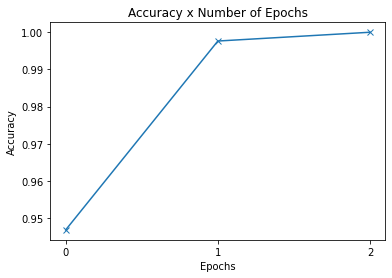

In [10]:
def plot_accuracy(history):
    accuracy = history["validation_accuracy"]
    epochs = range(len(accuracy))
    
    plt.plot(accuracy, "-x")
    plt.xticks(epochs)

    plt.title("Accuracy x Number of Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")


plot_accuracy(history)

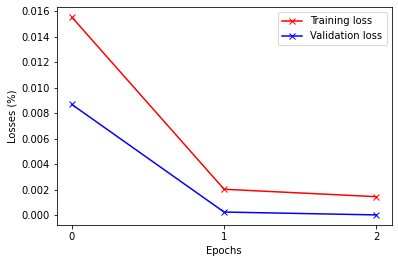

In [11]:
def plot_losses(history):
    train_loss = history["train_loss"]
    validation_loss = history["validation_loss"]
    epochs = range(len(train_loss))
    
    plt.plot(train_loss, "-rx")  # r = Red
    plt.plot(validation_loss, "-bx")  # b = Blue
    plt.xticks(epochs)
    
    plt.legend(["Training loss", "Validation loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses (%)")


plot_losses(history)

In [12]:
def evaluate(model, data_loader):
    correct_predictions = 0.0
    model.eval()
    y_hat = list()
    y_true = list()
    
    for (inputs, labels) in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_hat.append(preds)
        correct_predictions += torch.sum(preds == labels.data)

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return accuracy, y_true, y_hat


accuracy, y_true, y_hat = evaluate(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9925


                     precision    recall  f1-score   support

             Quince       1.00      0.98      0.99       164
   Grapefruit White       1.00      1.00      1.00       148
         Granadilla       1.00      1.00      1.00       160
             Orange       1.00      1.00      1.00       164
        Apple Red 3       1.00      1.00      1.00       161
      Grape White 2       1.00      1.00      1.00       164
          Corn Husk       0.93      1.00      0.96       152
          Tamarillo       0.99      1.00      0.99       164
         Banana Red       0.98      1.00      0.99       164
     Nectarine Flat       1.00      1.00      1.00       144
      Pepper Yellow       1.00      1.00      1.00       166
         Nut Forest       1.00      1.00      1.00       164
       Pear Monster       1.00      1.00      1.00       219
                Fig       1.00      1.00      1.00       164
       Tomato Heart       1.00      1.00      1.00       143
   Onion Red Peeled    

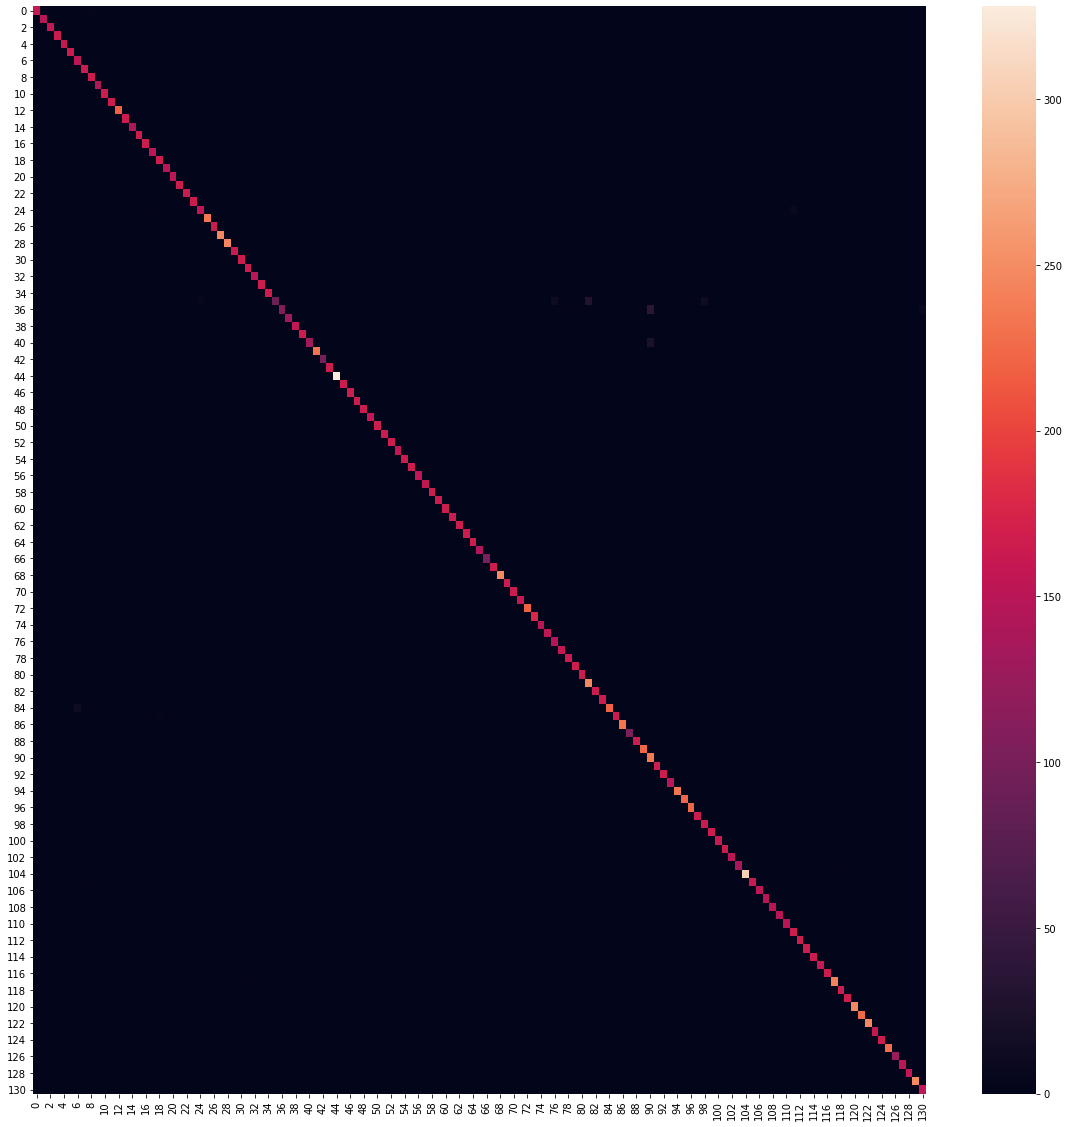

In [13]:
def evaluate_classes(data_loader, y_true, y_hat):
    Y_true = list()
    Y_hat = list()
    
    for inputs, labels in iter(data_loader):
        for y_true in labels.cpu().numpy():
            Y_true.append(y_true)

    for joint in y_hat:
        for label in joint.cpu().numpy():
            Y_hat.append(label)
        
    report = classification_report(Y_true, Y_hat, target_names=classes, zero_division=0)
    plt.rcParams["figure.figsize"] = (20,20)

    sns.heatmap(confusion_matrix(Y_true, Y_hat))
    
    return report


report = evaluate_classes(test_loader, y_true, y_hat)
print(report)